# Spectroscopic Retrieval

In the previous tutorials, we demonstrated how to simulate reflectance spectra using Hapke's model for single and multiple species. We now turn to the inverse problem: given a spectrum that contains noise and unknown mixtures, how can we estimate the surface composition and physical properties?

This process is called **spectroscopic retrieval**, and it involves comparing a forward model to observed data and inferring the most likely parameters (e.g., composition, grain size, porosity) using Bayesian inference techniques.

In this tutorial, we will:
- Retrieve the best-fit parameters for a noisy, simulated reflectance spectrum
- Quantify uncertainties on the retrieved values using posterior distributions
- Perform **Bayesian model comparison** to assess the evidence for each component in the mixture

In [1]:
# --- Notebook Setup ---
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import dynesty
from dynesty import NestedSampler
from dynesty.utils import resample_equal
from dynesty import plotting as dyplot
from multiprocessing import Pool
import importlib
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

# --- Imports from FROSTIE ---

import frostie.hapke as hapke
import frostie.utils as utils
import frostie.retrieval as retrieval
import frostie.plotting as plotting


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 



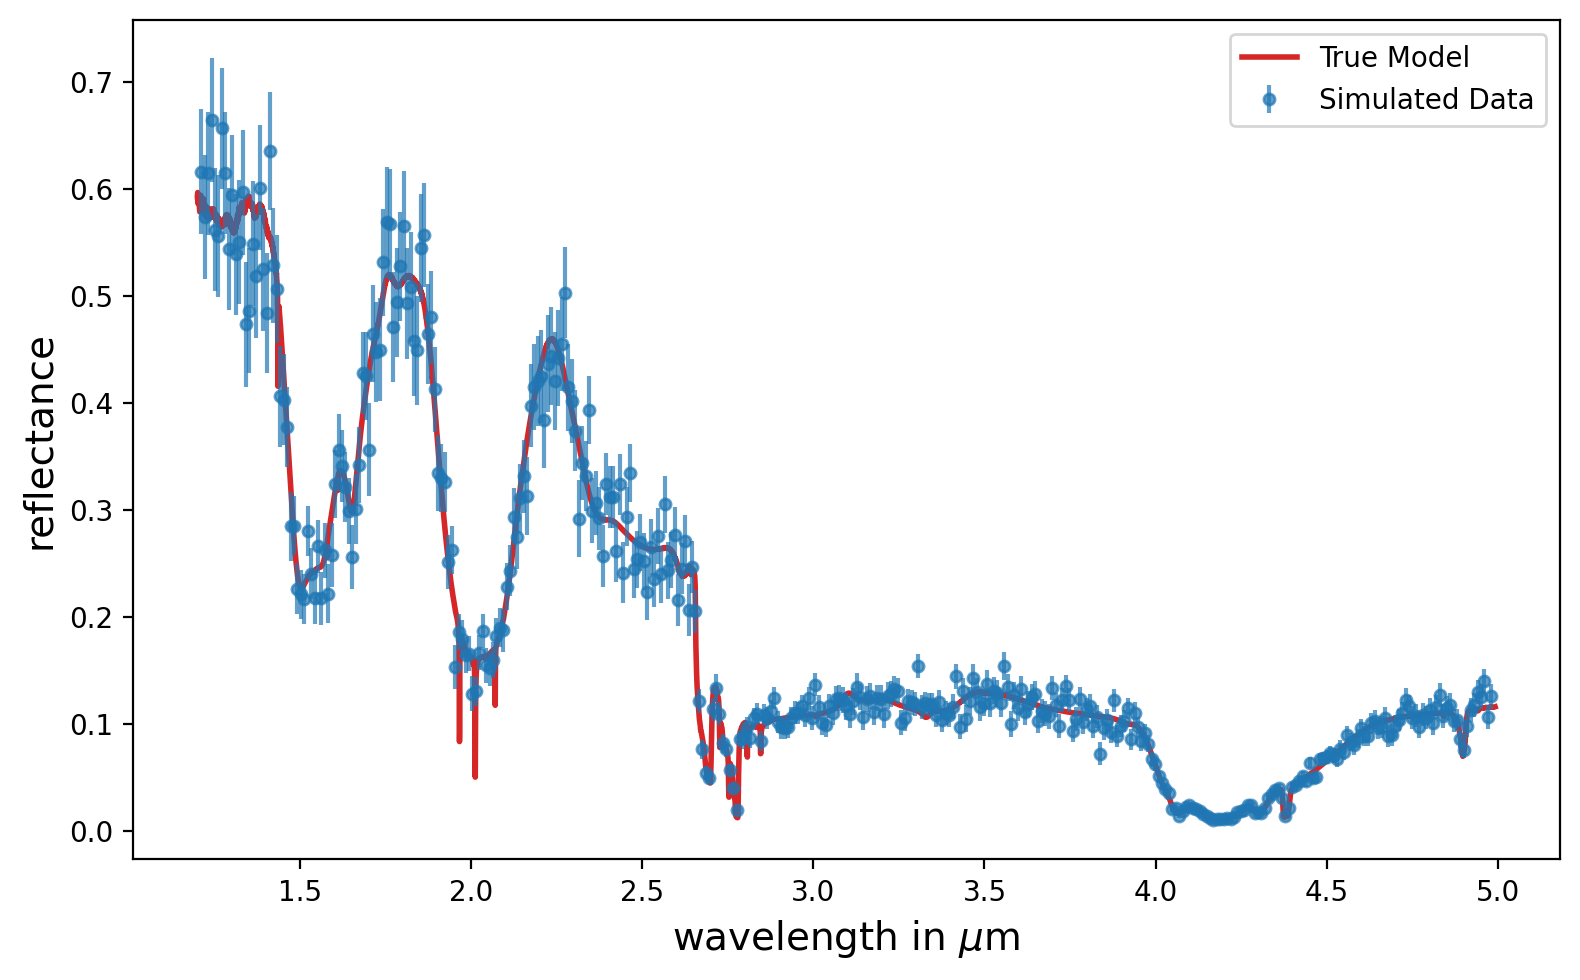

In [2]:
# --- 1. Load Simulated Data ---
# Load a synthetic reflectance spectrum with noise.
# The simulated surface contains a 50/50 mixture of H₂O and CO₂ ices,
# each with a grain size of 100 microns. Gaussian noise is added based on the specified SNR.

data_all = retrieval.load_simulated_data(snr=10, del_wav=0.01)


# Plot the true (noiseless) model and the simulated noisy data

plt.figure(figsize=(8,5))

# Plot the true model (noiseless)
plt.plot(data_all['wav_model'], data_all['model_true'], label='True Model', linewidth=2, 
         color='#d62728')

# Plot the noisy data with error bars
plt.errorbar(data_all['wavelengths'], data_all['reflectance'],
             yerr=data_all['uncertainty'], fmt='o', color='#1f77b4',
             markersize=4, label='Simulated Data', alpha=0.7)

plt.xlabel('wavelength in $\mu$m', fontsize=14)
plt.ylabel('reflectance', fontsize=14)
plt.legend()
plt.tight_layout()

### Retrieval using a single model

Let’s begin by applying our retrieval framework to a simple case: we assume the reflectance spectrum is composed of a mixture of H₂O and CO₂ ices, with grain sizes and porosity as free parameters.

This is a forward modeling problem that we now treat in reverse: we try to find the most probable values of the model parameters that fit the simulated data. We'll use **Bayesian nested sampling** to retrieve the full posterior distributions and the Bayesian evidence (logZ) for the model.

In [3]:
# --- 2. Set Up retrieval  ---

# create a nested_retrieval class object
example_retrieval = retrieval.solo_retrieval()

# Initialize the retrieval object with:
# - Fixed model parameters
# - Component optical constants
# - Free parameters and their bounds
# - Simulated dataset


# Define fixed model parameters
# Geometry parameters (i, e, g) are typically known from observation.
# We assume B=0 and s=0 here to simplify the model and reduce degeneracy.

fixed_params = {'p_type':'HG2', 'i':45, 'e':45, 'g':90,'B':0, 's':0, 'mixing_mode': 'intimate' }

wav_h2o, n_h2o, k_h2o = utils.load_water_op_cons()
wav_co2, n_co2, k_co2 = utils.load_co2_op_cons()

components = {'h2o':[wav_h2o, n_h2o, k_h2o], 'co2':[wav_co2, n_co2, k_co2]}

free_params = [
    ['log10f_h2o', (-3, 0)],  # f_h2o = 10^x, co2 fraction will be 1 - f_h2o if only 2 comps
    ['D_h2o', (10, 1000)],
    ['D_co2', (10, 1000)],
    ['p', (0.48, 1.0)]  # Porosity value needs to be higher than 0.48 for Hapke model to be valid
]

# set up the data list

data = [data_all['wavelengths'], data_all['reflectance'], data_all['uncertainty']]

# --- 6. Initialize ---
example_retrieval.initialize(
    fixed_params=fixed_params,
    free_params=free_params,
    components=components,
    data=data
)

In [ ]:
# --- 2. Run Retrievals ---

# Run the retrieval using nested sampling.
# Results (samples and logZ) will be saved in the working directory unless a custom path is specified.
# Multiprocessing is enabled here to significantly speed up the sampling process.

example_retrieval.run(use_multicore=True)  # something about how using multiprocessing can speed up dynesty runs

[INFO] solo_retrieval: using 9 cores for parallel processing.


iter: 10589 | +512 | bound: 111 | nc: 1 | ncall: 231994 | eff(%):  4.796 | loglstar:   -inf < 1100.841 <    inf | logz: 1082.510 +/-  0.181 | dlogz:  0.000 >  0.100                                  

Time taken for retrieval: 0h 0m 43s


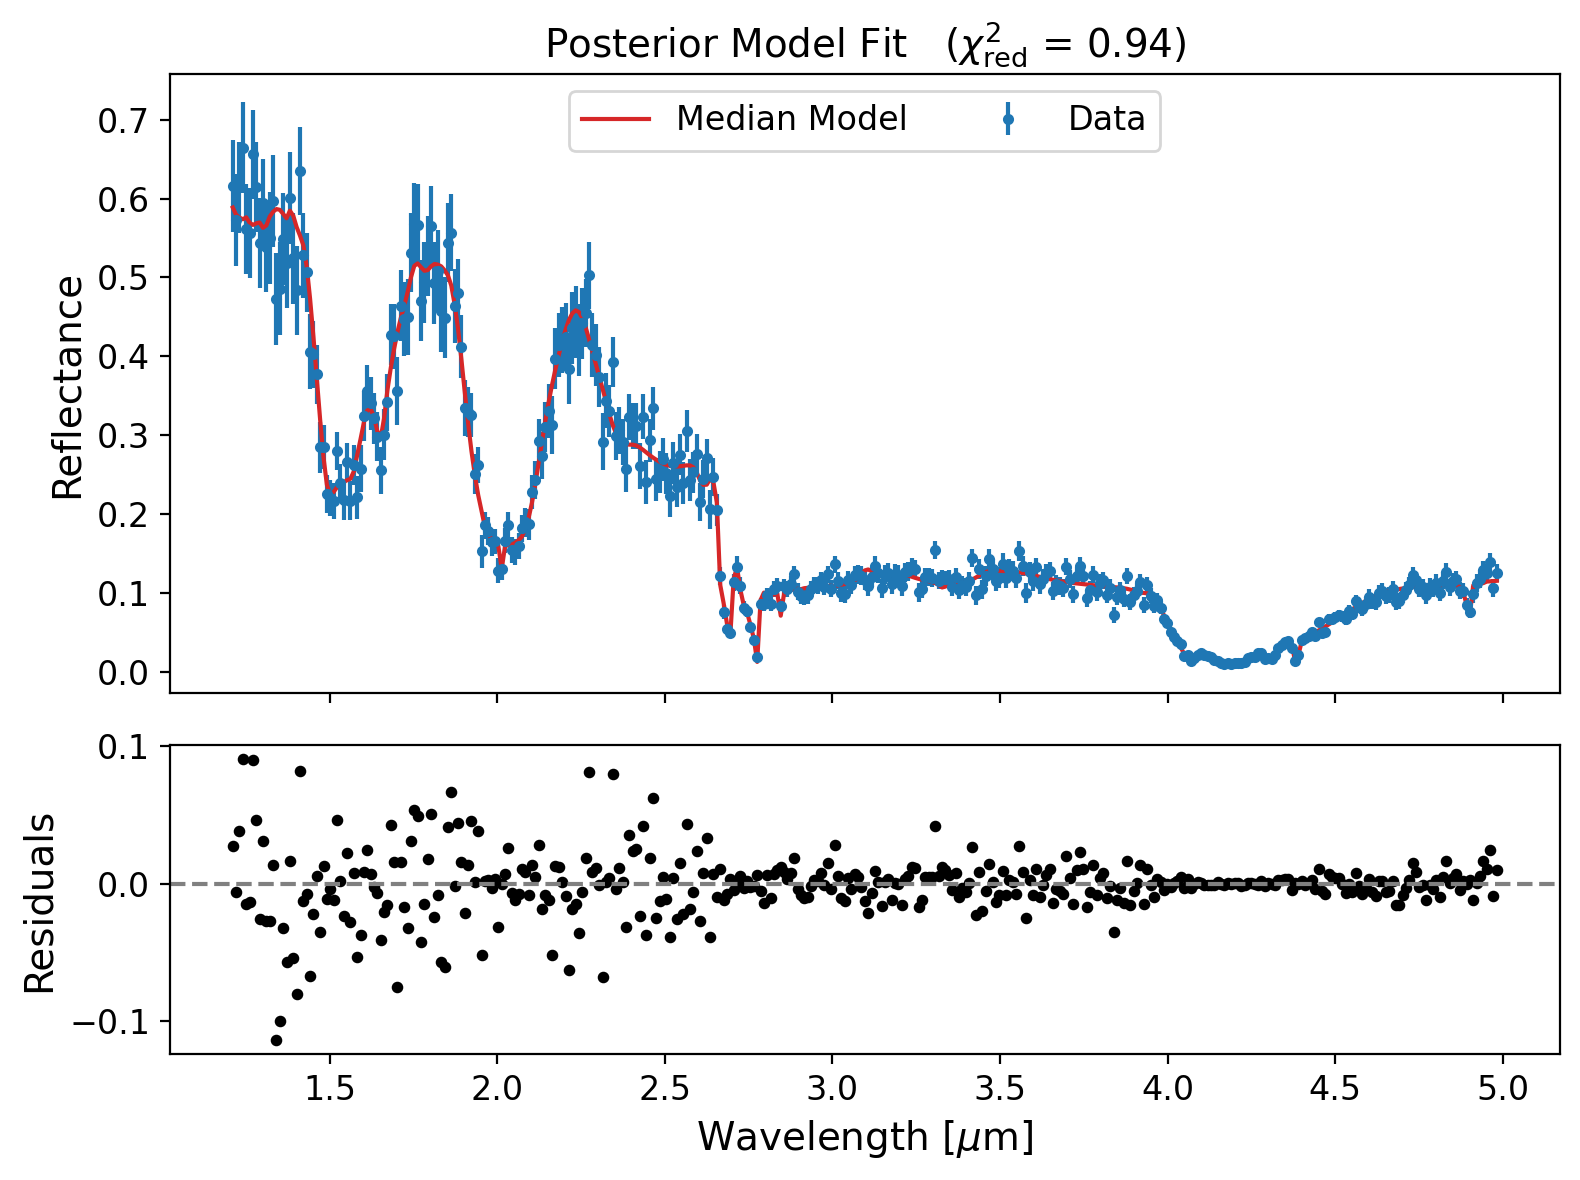

In [ ]:
# --- 3. Plot median model solution ---

# Plot the median model spectrum with 1σ and 2σ confidence intervals.
# Also shows the observed data and the fit residuals.

example_retrieval.plot_solutions()

### Interpreting the posterior distributions

The plots below show the marginalized posterior distributions for each free parameter in the model. These give us a sense of:

- The most likely value (median)
- The width of the credible intervals (2σ)
- Correlations between parameters (e.g., grain size and abundance)

Notice that the distributions are somewhat broad and correlated — this is expected, as there are **degeneracies** between physical parameters like abundance and grain size. A small amount of fine-grained material can produce a similar spectral shape as a larger amount of coarse-grained material. These trade-offs are naturally captured in the Bayesian framework.

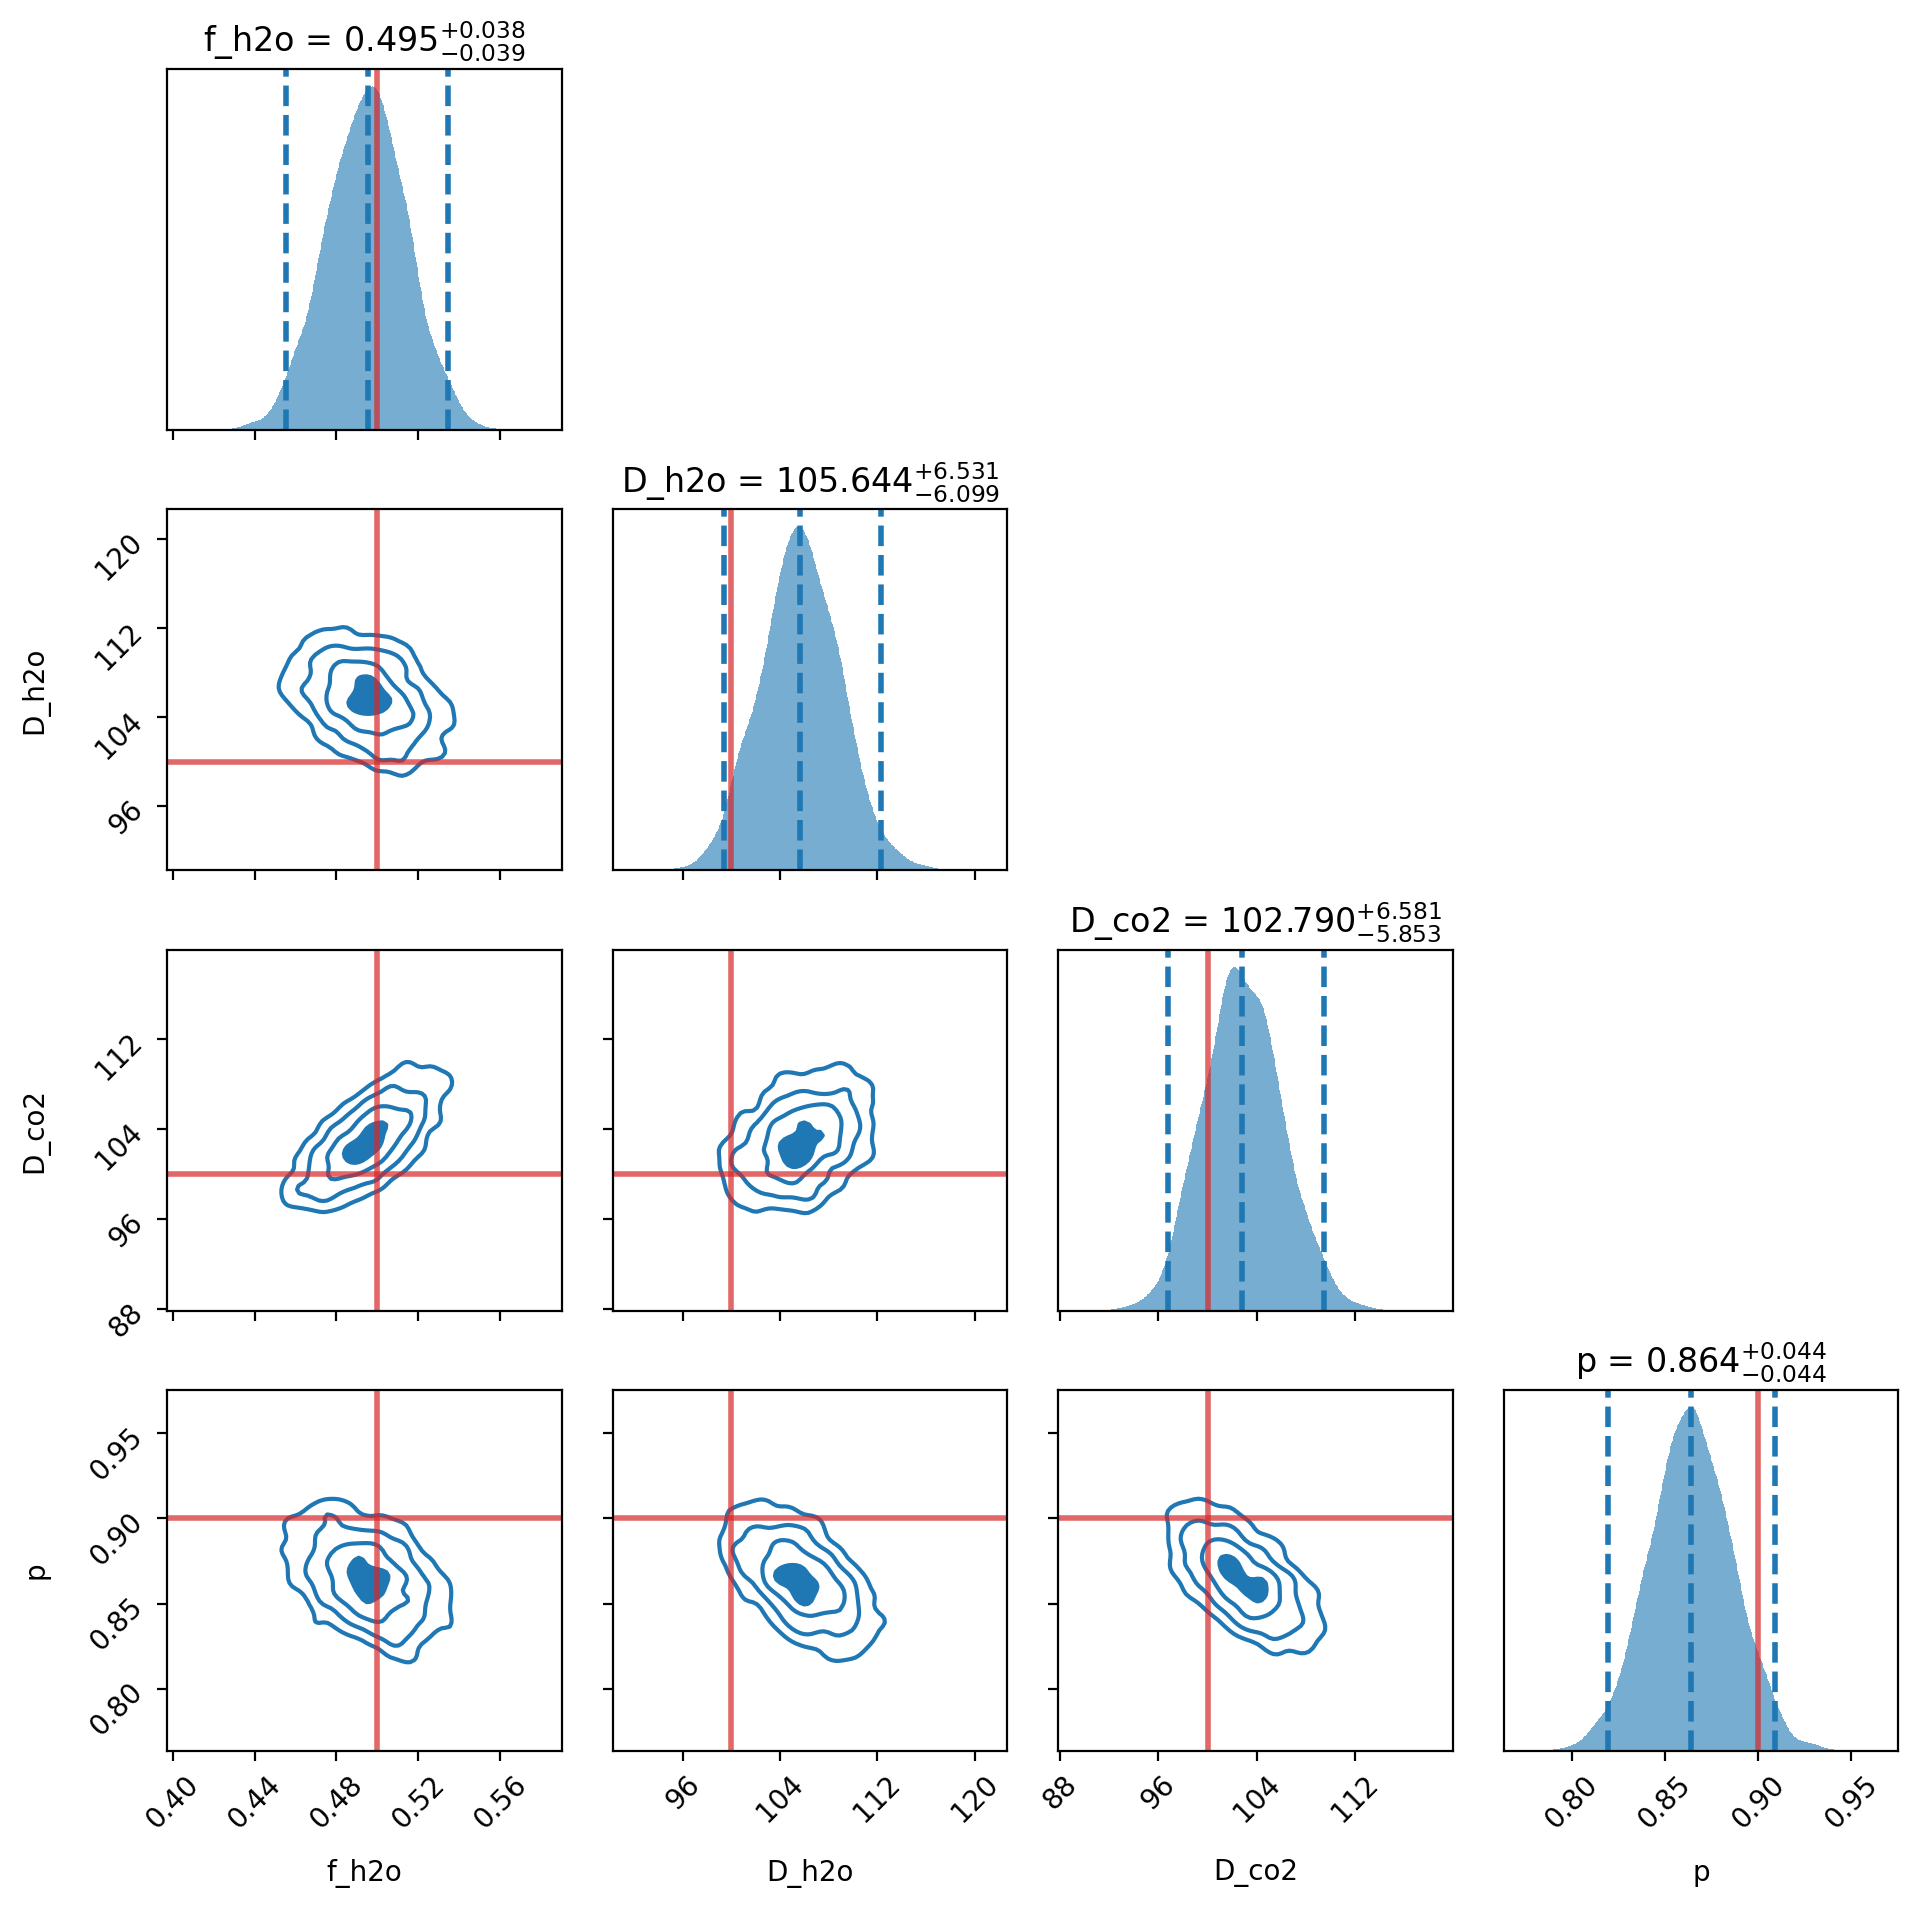

In [ ]:
# --- 4. Plot Posterior Distributions ---

# Plot the marginalized posterior distributions for each free parameter.
# The red vertical lines indicate the true values used to generate the simulated data.

truths = [0.5, 100, 100, 0.9]  # f_water, D_water, D_co2, porosity
example_retrieval.plot_posteriors(truths=truths)


In [ ]:
# --- 5. Print Retrieved Parameter Estimates ---

# Print the median and 1σ uncertainty bounds for each retrieved parameter.

example_retrieval.print_retrieval_summary()

Retrieved parameters (±2σ intervals):
f_h2o: 0.495 (+0.039 / -0.040)
D_h2o: 105.646 (+6.628 / -6.279)
D_co2: 102.771 (+6.618 / -5.981)
p: 0.864 (+0.045 / -0.044)


### Bayesian Model Comparison

So far, we have assumed that both H₂O and CO₂ are present in the spectrum. But how do we justify the inclusion of each component?

To address this, we use **Bayesian model comparison** or **BMC**, which quantifies how strongly the data support one model over another. The procedure is:

1. Run one retrieval with the full model (all components included).
2. Run separate retrievals excluding one component at a time.
3. Compare the Bayesian evidences (logZ values) for each model.

We interpret the difference in log-evidence (ΔlogZ) using its equivalent **sigma-level significance** — this tells us how confidently we can say a particular component is required to explain the data.

The flowchart below from [Mishra et al. (2021a)](https://iopscience.iop.org/article/10.3847/PSJ/ac1acb/meta) shows how the BMC logic helps us select the best set of molecules/species that fit the data:

<p align="center">
  <img src="bmc.png" alt="Description" width="500"/>
</p>

For a detailed explanation of BMC, please refer to [Mishra et al. (2021b)](https://arxiv.org/abs/2012.05240).

Now, we want to quantify the evidence of both H $_2$ O and CO $_2$ in the data. That is, we want to test the hypotheses that this data shows strong evidence for both H $_2$ O and CO $_2$.

In [3]:
# --- 2. Set Up Bayesian model comparison  ---

# Run a series of retrievals to compare models with different combinations of species.
# One run includes all species (H₂O + CO₂), while others exclude one species at a time.
# The Bayesian evidence (logZ) is used to assess which components are required by the data.

# create a nested_retrieval class object
example_model_comparison = retrieval.nested_retrieval()

# intialize the retrieval class object with a list of fixed parameters, component names and corresponding optical constants, and list of free parameters and their bounds

# define fixed model parameters 
fixed_params = {'p_type':'HG2', 'i':45, 'e':45, 'g':90,'B':0, 's':0, 'mixing_mode': 'intimate' }

wav_h2o, n_h2o, k_h2o = utils.load_water_op_cons()
wav_co2, n_co2, k_co2 = utils.load_co2_op_cons()

components = {'h2o':[wav_h2o, n_h2o, k_h2o], 'co2':[wav_co2, n_co2, k_co2]}

free_params = [
    ['log10f', (-3, 0)],   # always log10 of the primary species
    ['D', (10, 1000)],
    ['p', (0.48, 1.0)]
]

# set up the data list

data = [data_all['wavelengths'], data_all['reflectance'], data_all['uncertainty']]

# initialize retrieval object

example_model_comparison.initialize(
    fixed_params=fixed_params,
    free_params=free_params,
    components=components,
    data=data
)

# run the retrieval

example_model_comparison.run_all_models(use_multicore=True)

[INFO] nested_retrieval: using 9 cores for parallel processing.

>>> Running retrieval for model: h2o_co2
[INFO] solo_retrieval: using 9 cores for parallel processing.


iter: 10536 | +512 | bound: 110 | nc: 1 | ncall: 230356 | eff(%):  4.807 | loglstar:   -inf < 1100.846 <    inf | logz: 1082.616 +/-  0.180 | dlogz:  0.000 >  0.100                                  

Time taken for retrieval: 0h 0m 45s

>>> Running retrieval for model: co2
[INFO] solo_retrieval: using 9 cores for parallel processing.


iter: 13437 | +512 | bound: 145 | nc: 1 | ncall: 275765 | eff(%):  5.068 | loglstar:   -inf < -60122.958 <    inf | logz: -60146.858 +/-  0.207 | dlogz:  0.000 >  0.100                              

Time taken for retrieval: 0h 0m 36s

>>> Running retrieval for model: h2o
[INFO] solo_retrieval: using 9 cores for parallel processing.


iter: 7293 | +512 | bound: 69 | nc: 1 | ncall: 140373 | eff(%):  5.581 | loglstar:   -inf < -4990.248 <    inf | logz: -5002.138 +/-  0.144 | dlogz:  0.000 >  0.100                                  

Time taken for retrieval: 0h 0m 18s


In [4]:
# --- 3. Compute Evidence ---

# Compare the Bayesian evidences of all models.
# Converts logZ differences into sigma confidence values for each species.

example_model_comparison.compare_evidences()


=== Bayesian Evidence Comparison ===
Evidence for: h2o → >10.0σ (ΔlogZ = >100.00)
Evidence for: co2 → >10.0σ (ΔlogZ = >100.00)

Best model: h2o_co2 (logZ = 1082.62)


> **Note:**  
> When the Bayesian evidence exceeds >10σ or ΔlogZ > 100, it indicates that the excluded-species model is overwhelmingly disfavored by the data. In practical terms, this means the missing component is almost certainly required to reproduce the observed spectrum. These extreme values are common when the excluded species contributes strongly to distinct absorption features in the data.

### Evidence values and species detection

After running all model variants, we compare their log-evidences to compute the **Bayes factor** and convert it into a sigma-equivalent confidence level for each species.

A ΔlogZ of ~5 corresponds to ~3σ evidence — often considered strong support in planetary remote sensing. If a species' exclusion results in a large drop in logZ, we can confidently say it is required in the mixture.

In this example, we simulated a spectrum with 90% H₂O and 10% CO₂. The model comparison results below confirm the presence of both species, with very strong evidence (>10σ) for both species. This reflects the ability of the retrieval framework to strongly resolve even small fractional contributions like CO₂.

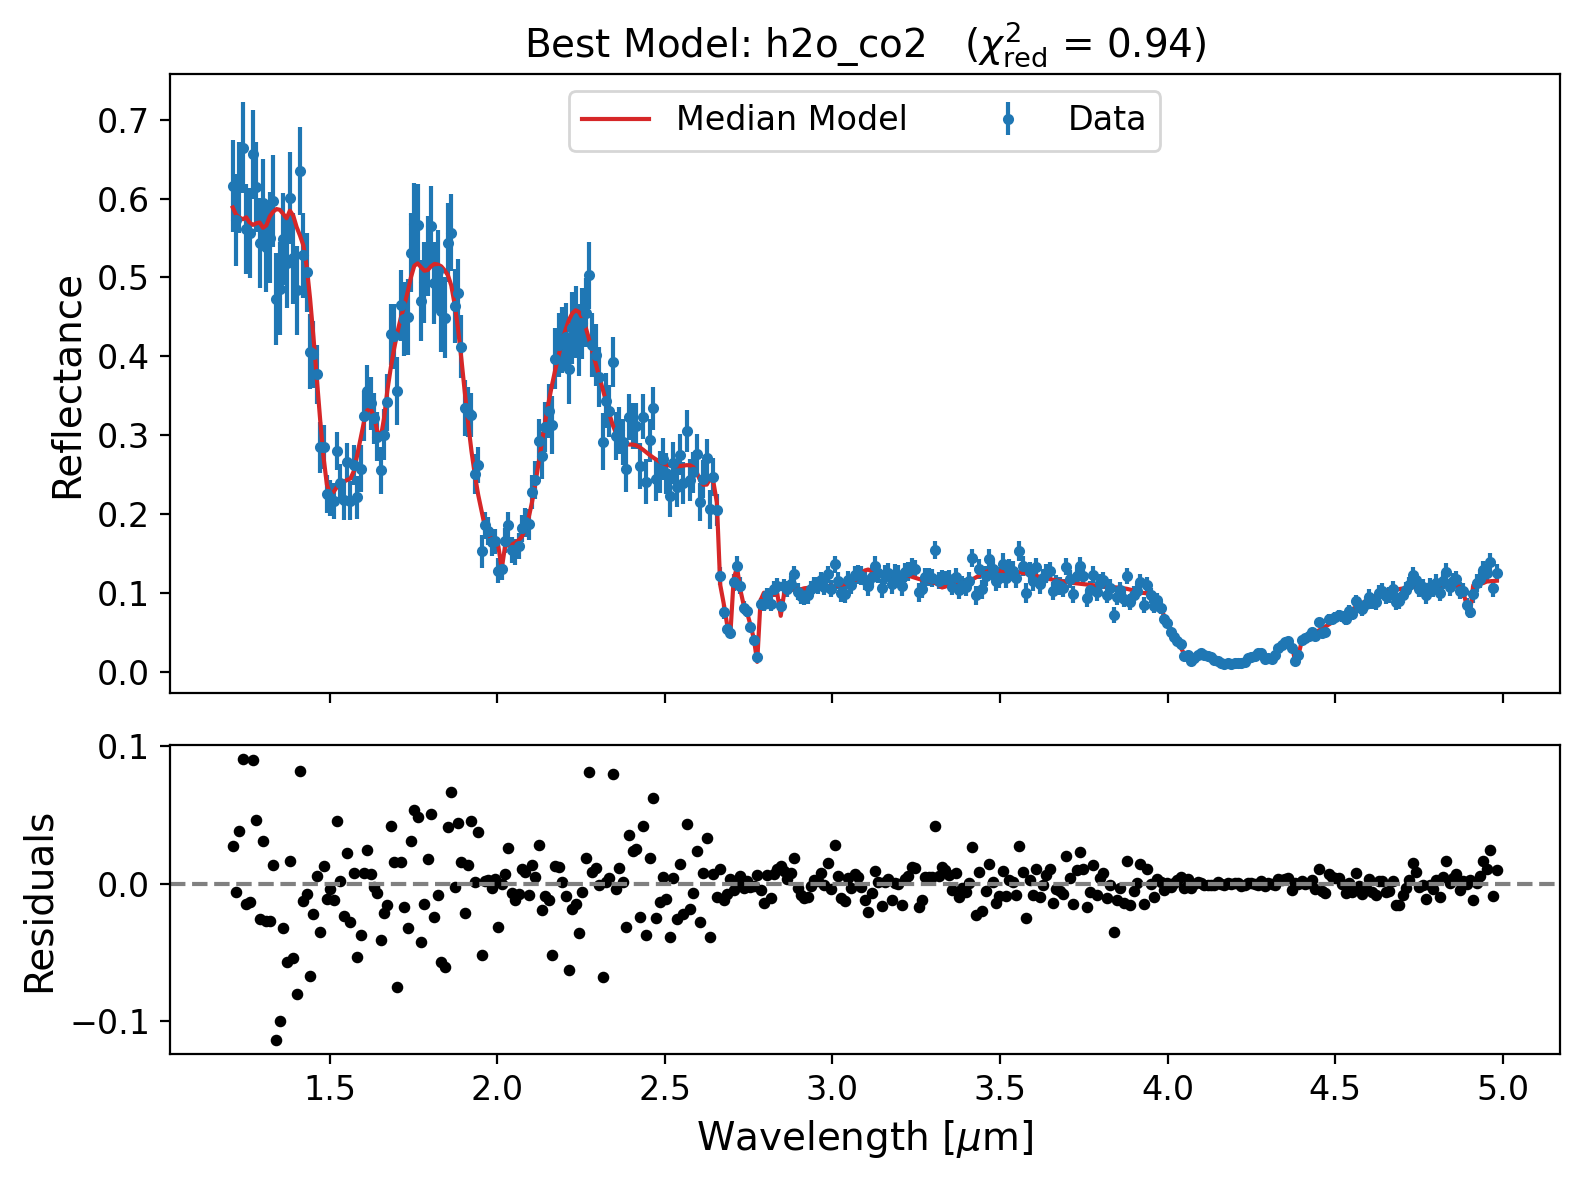

In [ ]:
# --- 4. Plot solutions of best Model ---

example_model_comparison.plot_best_model_solutions()

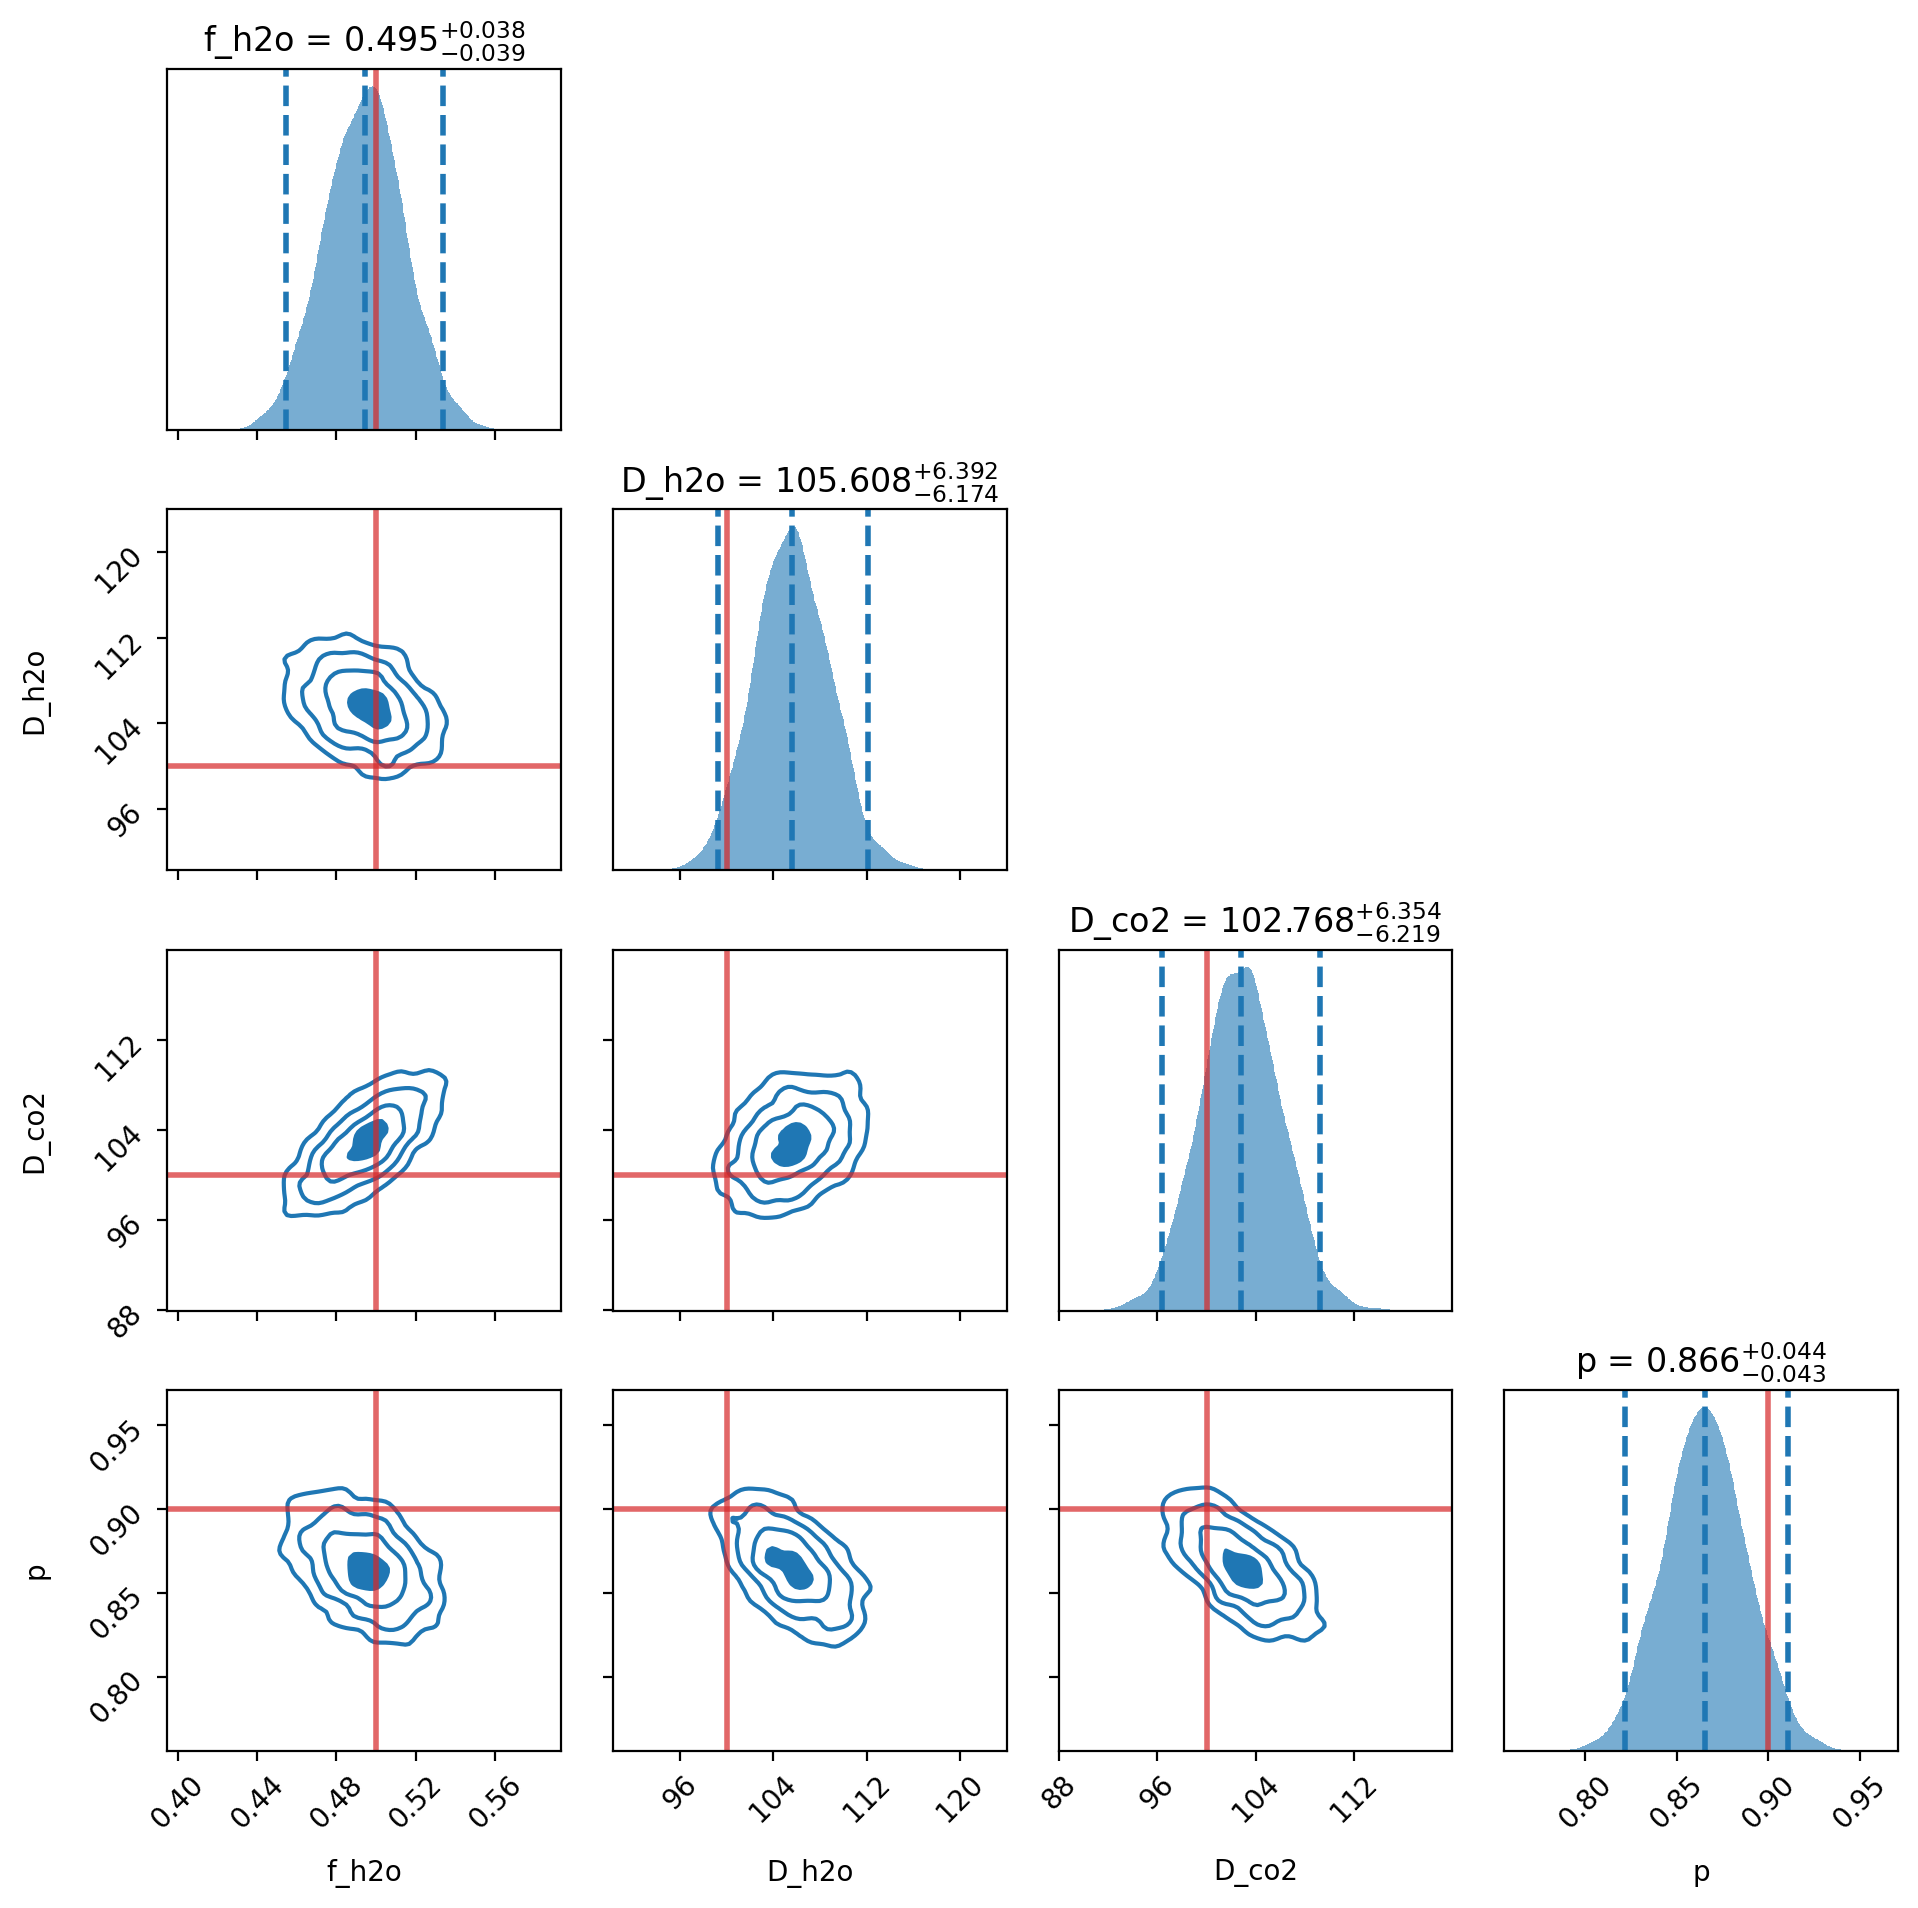

In [ ]:
# --- 5. Plot Posterior Distributions ---

truths = [0.5, 100, 100, 0.9]  # f_water, D_water, D_co2, porosity
example_model_comparison.plot_best_model_posteriors(truths=truths)


In [ ]:
# --- 6. Print Retrieved Parameter Estimates ---

example_model_comparison.print_best_model_summary()


Retrieved parameters (±2σ intervals):
f_h2o: 0.495 (+0.039 / -0.040)
D_h2o: 105.608 (+6.467 / -6.339)
D_co2: 102.760 (+6.494 / -6.360)
p: 0.866 (+0.045 / -0.044)


### Inspecting alternative fits

To understand how the fit degrades when a key component is missing, we can inspect the model solutions and posterior distributions for the reduced models.

Below, we plot the spectrum and residuals for the H₂O-only model. While the overall shape is captured, the fit breaks down beyond ~3 µm, where CO₂ has a strong absorption feature. This reinforces the need for including CO₂ in the model — a point already supported quantitatively by the log-evidence.

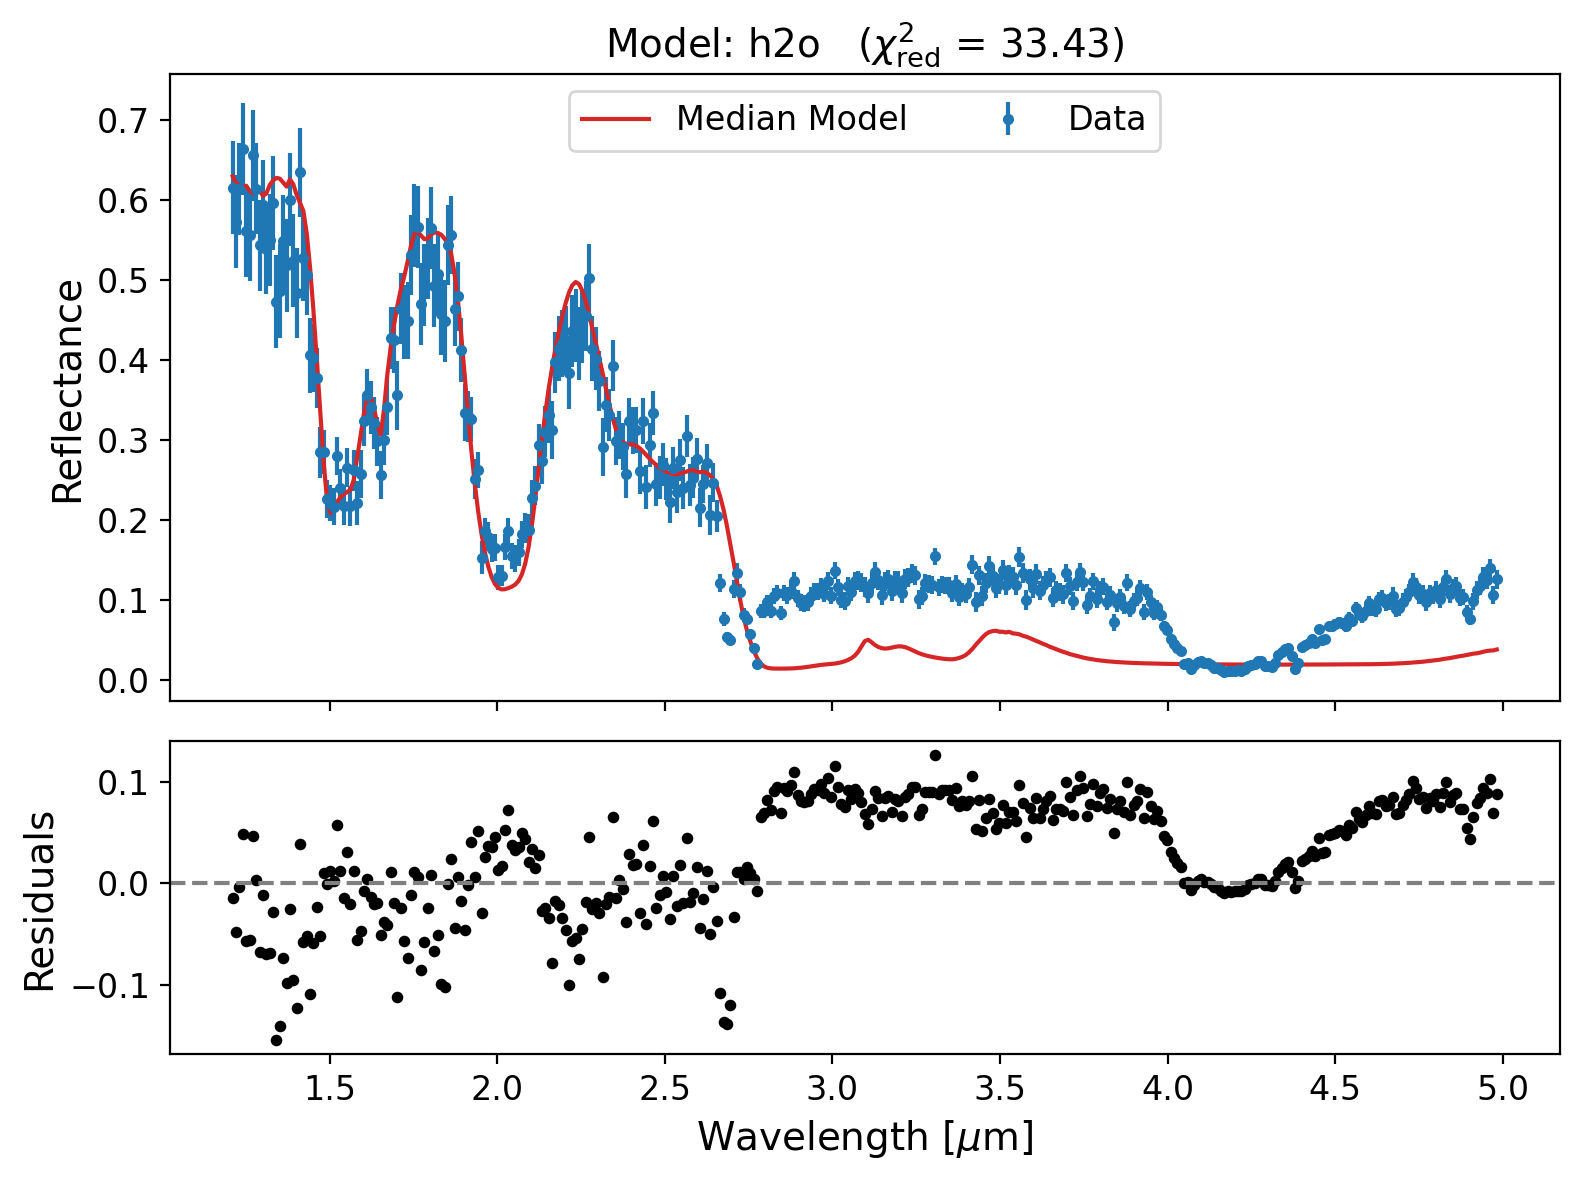

In [14]:
example_model_comparison.plot_model('h2o')

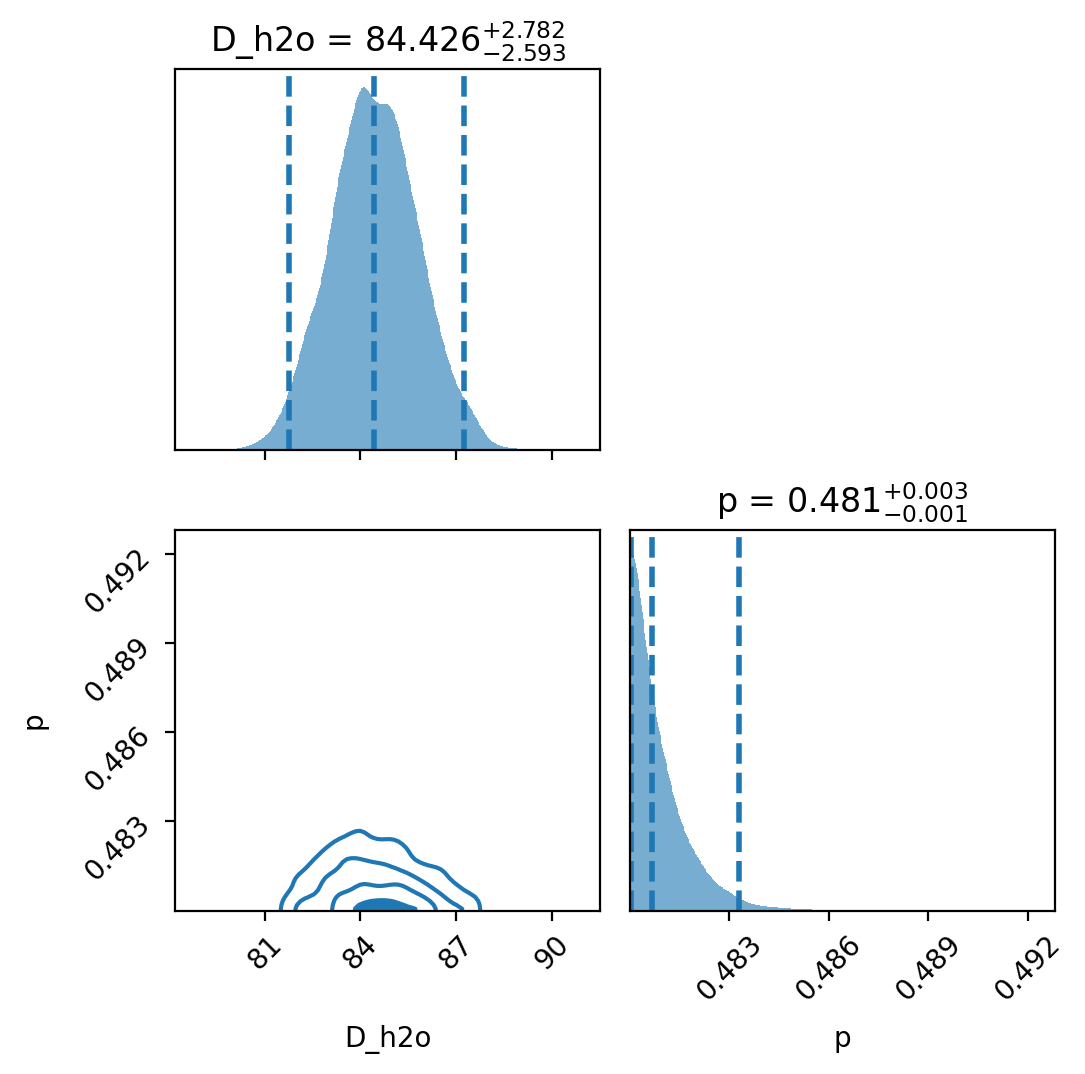

In [ ]:
# Show the posterior distributions for the H₂O-only model.
# Note the broader uncertainties and any shifts relative to the full model.

example_model_comparison.plot_model_posteriors('h2o')

### Summary

This tutorial demonstrated how to use the FROSTIE package to:

- Retrieve model parameters and uncertainties from reflectance spectra
- Evaluate the Bayesian evidence of competing spectral models
- Interpret degeneracies and fit quality using both posteriors and residuals

Together, these tools allow for a robust analysis of planetary surface composition — not just identifying which species might be present, but quantifying how confident we can be in each detection.

For more details on the underlying algorithms, refer to Mishra et al. (2021a, 2021b).
